In [5]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import sys
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error as mse
from importlib import reload
import scipy.io
import matplotlib.cm as cm
import pickle
import matplotlib as mpl
import shutil
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print(tf.__version__)
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization,Input
from tensorflow.keras.models import load_model, Model,Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger,ReduceLROnPlateau
gpus = tf.config.experimental.list_physical_devices('GPU') 
from sklearn.metrics import r2_score, mean_squared_error
if gpus:
    try:
        for gpu in gpus:
            limit =  8192# 10G memory per GPU
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=limit)]
            )
        tf.config.set_visible_devices(gpus[1], 'GPU')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

2.15.0


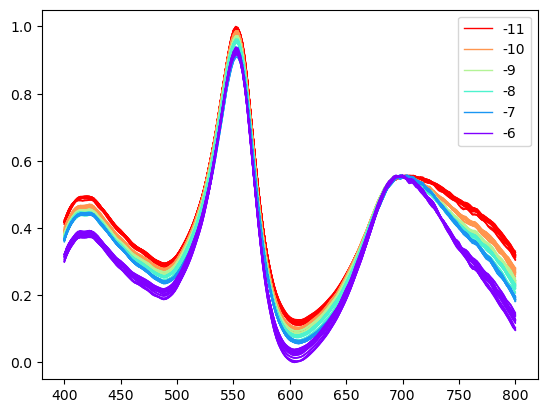

In [6]:
test_split_method = 'batch'
remove_concentration= [0]
data_dir = './data/dopamine_uric/'
wls = np.loadtxt(data_dir+'wavelengths.txt')
X_an = np.load(data_dir+'X.npy')
df = pd.read_csv(data_dir+'labels.csv')
df['status'] = 'train'
if test_split_method == 'batch':
    for concentration in df['concentration'].unique():
        # Get unique batches for this concentration
        batches = df[df['concentration'] == concentration]['batch'].unique()
        # Randomly select 1/4 of these batches for the test set, minimum 1
        test_batches = np.random.choice(batches, max(1, len(batches) // 4), replace=False)
        # Label the selected batches as 'test'
        df.loc[(df['concentration'] == concentration) & (df['batch'].isin(test_batches)), 'status'] = 'test'
elif test_split_method== 'sample':
    # Randomly select 1/4 of the samples for the test set, minimum 1
    test_samples = np.random.choice(df.index, max(1, len(df) // 5), replace=False)
    df.loc[df.index.isin(test_samples), 'status'] = 'test'
df = df[~df['concentration'].isin(remove_concentration)]
X_an = X_an.reshape(-1,201)[df.index]
X_an = X_an.reshape(-1,30,201)
c_list = np.unique(df.concentration)
colors = cm.rainbow_r(np.linspace(0, 1, len(c_list)))
for c in range(len(X_an)):
    legend_flag = 1
    for b in np.arange(0,30):
        if legend_flag:
            plt.plot(wls,X_an[c,b],color=colors[c],alpha=1,linewidth=1,label=c_list[c])
            legend_flag = 0
        else:
            plt.plot(wls,X_an[c,b],color=colors[c],alpha=1,linewidth=1)
plt.legend()

In [7]:
X = X_an.reshape(len(c_list)*30,-1)
Y = np.array(df.concentration)
Y_reg = (Y-Y.min()) / (Y.max()-Y.min())

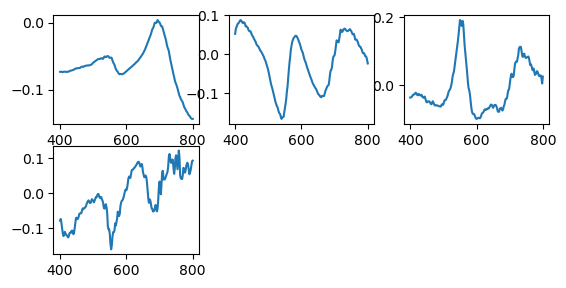

In [9]:
pca = PCA(n_components=8, svd_solver='full')
pc=pca.fit_transform(X)
pca_components = pca.components_
for i in range(4):
    plt.subplot(3,3,i+1)
    plt.plot(wls,pca_components[i])
np.save(data_dir+'pca4.npy',pca_components)

In [24]:
from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y_reg, test_size=0.2)
X_train = X[df.status=='train']
Y_train = Y_reg[df.status=='train']
X_test = X[df.status=='test']
Y_test = Y_reg[df.status=='test']

N_PCA=8
early_stopper = EarlyStopping(monitor='loss',patience=15)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,verbose=0,
                              patience=4, min_lr=1e-6)
model=Sequential(name='test')
#model.add(BatchNormalization())
model.add(Dense(32,activation='relu',input_shape=(N_PCA,)))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
# model.add(Dense(16,activation='relu',input_shape=(N_PCA,)))
# model.add(Dense(16,activation='relu'))
# model.add(Dense(32,activation='relu'))
# model.add(Dense(1,activation='sigmoid'))
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse',metrics='mae')
#model.summary()
#pca = PCA(n_components=N_PCA, svd_solver='full')
#pc=pca.fit_transform(X_train)
# pca.fit(X_train)
pca_components = np.load(data_dir+'pca8.npy')
pc = np.matmul(X_train,pca_components.T)

pc1 = (pc-np.min(pc,axis=0))/(np.max(pc,axis=0)-np.min(pc,axis=0))
history=model.fit(pc1,Y_train,epochs=100,verbose=0,batch_size=8,
                  callbacks=[reduce_lr,early_stopper])
#plt.plot(history.history['loss'])

2/2 [==============================] - 0s 1ms/step


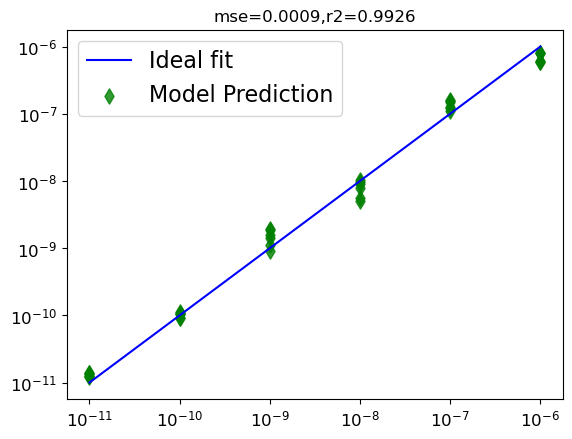

In [28]:
#model=load_model('models/uric9926.h5')
def unnorm(y):
    return y * (Y.max() - Y.min())+Y.min()
from sklearn.metrics import r2_score, mean_squared_error
# pc_test =pca.transform(X_test)
pc_test=np.matmul(X_test,pca_components.T)
pc_test=(pc_test-np.min(pc,axis=0))/(np.max(pc,axis=0)-np.min(pc,axis=0))
#error = model.evaluate(pc_test,Y_test)
Y_pred = model.predict(pc_test)
test_r2=r2_score(unnorm(Y_test),unnorm(Y_pred))
error = mean_squared_error(Y_test,Y_pred)
alp=0.8
s=60
#min_concentration = np.max(c_list) * -1
x_ax=np.arange(np.min(c_list),np.max(c_list)  +1)
plt.plot(x_ax,x_ax,'b')
plt.scatter(unnorm(Y_test),unnorm(Y_pred),marker='d',color='green',alpha=alp,s=s)
plt.legend(['Ideal fit','Model Prediction'],fontsize=16)
ticks=[]
for c in x_ax:
    ticks.append("$10^{"+str(c)+"}$")
plt.xticks(1*x_ax,ticks,fontsize=12)
plt.yticks(1*x_ax,ticks,fontsize=12)
plt.title('mse={:.4f},r2={:.4f}'.format(error,test_r2))
r2_text = "{:.4f}".format(test_r2)
r2_text = r2_text [2:]
#model.save(f'models/uric{r2_text}.h5')

In [30]:
## Importance Analysis
from importance_analysis import *
ig_data = pc
imp_scores = []
for i in range(len(ig_data)):
    input_vector = ig_data[i]
    imp_score = zero_baseline_integrated_gradients(input_vector, model, num_steps=30, num_runs=5)
    imp_scores.append(imp_score.numpy())
imp_scores = np.array(imp_scores)
print(np.mean(imp_scores,axis=0),'\n',np.std(imp_scores,axis=0))
print(np.argsort(np.abs(np.mean(imp_scores,axis=0)))[::-1])
np.savetxt('IGs/uric_zero.txt',np.mean(imp_scores,axis=0))

2.15.0
[ 0.34287897 -0.01486596  0.02061166  0.02679203  0.07353289 -0.14455408
 -0.01700147 -0.00369104] 
 [0.01100977 0.0015894  0.00274871 0.00358545 0.0055552  0.0187418
 0.0028614  0.00020665]
[0 5 4 3 2 6 1 7]


In [32]:
## Importance Analysis
from importance_analysis import *
ig_data = np.concatenate([pc,pc_test],axis=0)
imp_scores = []
for i in range(len(ig_data)):
    input_vector = ig_data[i]
    #imp_score = zero_baseline_integrated_gradients(input_vector, model, num_steps=20, num_runs=2)
    imp_score = random_baseline_integrated_gradients(input_vector, model, num_steps=30, num_runs=10)
    imp_scores.append(imp_score.numpy())
imp_scores = np.array(imp_scores)
print(np.mean(imp_scores,axis=0),'\n',np.std(imp_scores,axis=0))
print(np.argsort(np.abs(np.mean(imp_scores,axis=0)))[::-1])
s=np.abs(np.mean(imp_scores,axis=0))
np.savetxt('IGs/uric_random.txt',np.mean(imp_scores,axis=0))

[ 0.50873905 -0.02634549 -0.01027591 -0.04172486  0.02210151 -0.05251666
 -0.02596322  0.00148529] 
 [0.255844   0.01755917 0.0376446  0.08140934 0.01995179 0.03382856
 0.01652728 0.00540704]
[0 5 3 1 6 4 2 7]


IMP=0.8711623696802285, VAR=0.963993824434442


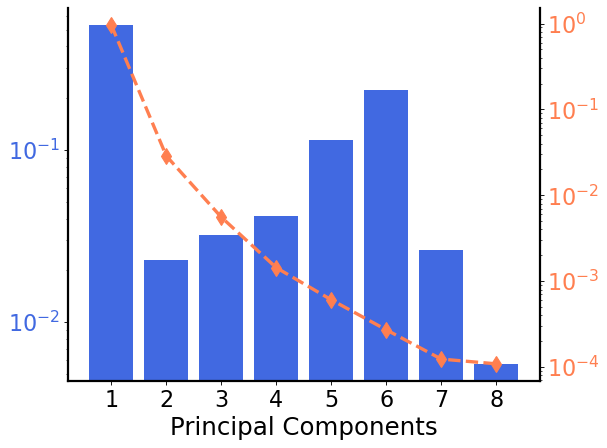

In [33]:
d1 = np.abs(np.loadtxt('IGs/uric_zero.txt'))
plt.rcParams["font.size"]=20
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["ps.useafm"] = True
plt.rcParams["font.family"]='sans-serif'
d2 = pca.explained_variance_  # Second dataset with a different scale

x = np.arange(len(d1))  # Common x-axis for both datasets

fig, ax1 = plt.subplots(figsize=(8, 6),dpi=80)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
color = 'royalblue'
ax1.set_xlabel('Principal Components',fontsize=22)
#ax1.set_ylabel('Importance Score',fontsize=16)
ax1.bar(x, d1/np.sum(d1),color=color,label='Importance Score')
ax1.semilogy()
ax1.tick_params(axis='y', labelcolor=color)
plt.xticks(np.arange(0,8),np.arange(0,8)+1)
#ax1.tick_params(axis='x', labelsize=14)
#ax1.legend()


# Creating a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
color = 'coral'
#ax2.set_ylabel('Variance',fontsize=16)
ax2.plot(x, d2/np.sum(d2),color=color,marker='d',linestyle='--',markersize=10,linewidth=3,label='Variance')
ax2.semilogy()
ax2.tick_params(axis='y', labelcolor=color)
#plt.legend()
fig.tight_layout()  # Adjust the layout to make room for the second y-axis
chosen_pc = np.argsort(d1)[::-1][:3]
total_imp=np.sum(d1[chosen_pc])/np.sum(d1)
total_var = np.sum(pca.explained_variance_[chosen_pc])/np.sum(pca.explained_variance_)
print(f'IMP={total_imp}, VAR={total_var}')
plt.show()


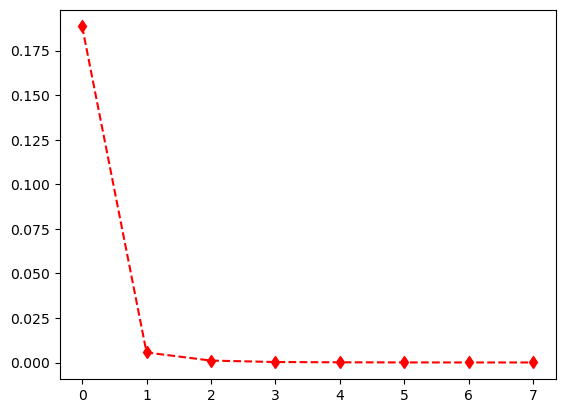

In [12]:
plt.plot(x, d2,color='r',marker='d',linestyle='--')


In [5]:
DATADIR = '/home/wjoe/data/dataset/Alfred/vis400_800_201pts/'
all_data = pd.read_csv(DATADIR + 'data.csv')
# all_data = all_data[all_data.nx!=150]
spectras = np.load(DATADIR + 'spectra.npy')
labels  = np.load('/home/wjoe/data/dataset/Alfred/labels.npy',allow_pickle=True)

wl = np.linspace(400, 800, 201)

In [14]:
dz = 0.2
scores = np.load(f'./design4/dopamine_uric/{dz}/scores.npy')
indexes = np.load(f'./design4/dopamine_uric/{dz}/indexes.npy')
best = indexes[np.argmax(scores)]
batch = spectras[best]
data = all_data.iloc[best]
pca_components = np.load('./data/dopamine_uric/pca8.npy')

In [15]:
from dataset_search import FuncFitting
from sklearn.linear_model import LinearRegression, Lasso, Ridge
num_c = len(best)
regr = FuncFitting(wl,pca_components,nmodes=num_c, fitting='data', fitting_params={'arr' : batch}, regression=Ridge(alpha=0.001))
print(regr.score_)

0.44744665678299234


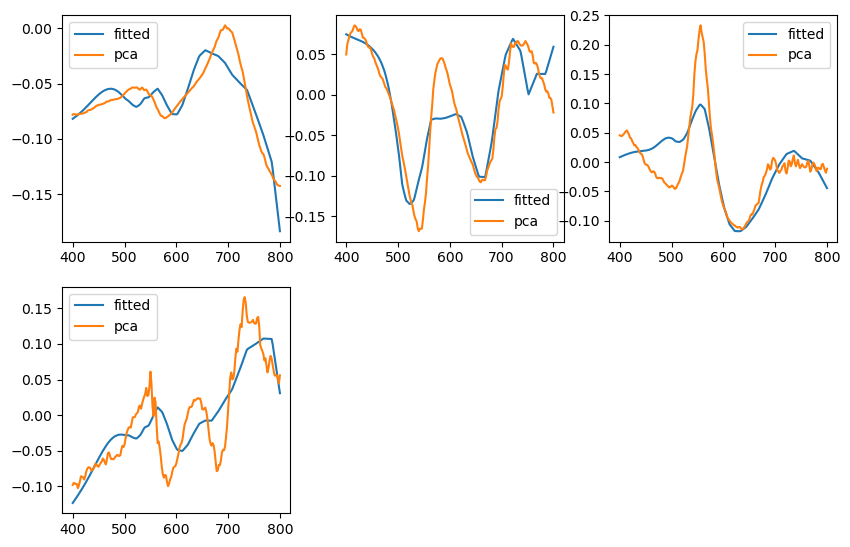

In [16]:
fit_components_ = np.zeros([num_c, len(wl)])
plt.figure(figsize=[10,10])
for i in range(num_c):
    fit_components_[i] = regr.get_fs()[i](wl)+regr.model.intercept_[i]
    plt.subplot(3,3,i+1)
    plt.plot(wl,fit_components_[i],label='fitted')
    plt.plot(wl,pca_components[i],label='pca')
    plt.legend()
plt.show()

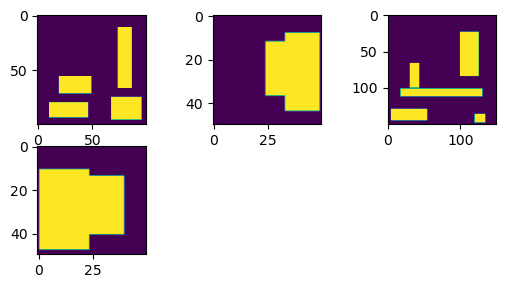

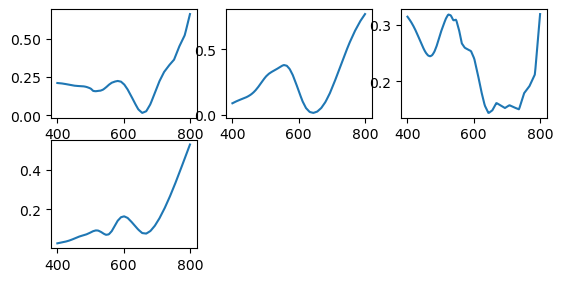

In [22]:
def generate_shapes(label, canvas_size):
    canvas = np.zeros(canvas_size, dtype=int)
    for _,coords in label:
        # Calculate the corners of the rectangle
        (center_x, center_y),x_length, y_length = coords
        x_start = int(max(center_x - np.floor(x_length / 2), 0))
        x_end = int(min(center_x + np.ceil(x_length / 2), canvas_size[1]))
        y_start = int(max(center_y - np.floor(y_length / 2), 0))
        y_end = int(min(center_y + np.ceil(y_length / 2), canvas_size[0]))
        # Draw the rectangle on the canvas
        canvas[x_start:x_end,y_start:y_end] = 1
    return canvas
label = labels[best]
shapes = []
for i in range(4):
    coords = label[i]
    dim = data.iloc[i].nx
    shape = generate_shapes(label[i],(dim,dim))
    plt.subplot(3,3,i+1)
    plt.imshow(shape)
    #shapes.append(shape)
    np.save(f'./design4/dopamine_uric/encoder{i}.npy',shape)
    
plt.figure()
for i in range(4):
    plt.subplot(3,3,i+1)
    plt.plot(wl,batch[i])
#np.save('../metasurface/encoder9.npy',batch)


In [23]:
label

array([list([['rectangle', [(85, 82), 21, 28]], ['rectangle', [(39, 80), 56, 13]], ['rectangle', [(87, 29), 14, 36]], ['rectangle', [(64, 35), 16, 30]]]),
       list([['rectangle', [(24, 33), 25, 19]], ['rectangle', [(26, 41), 36, 16]]]),
       list([['rectangle', [(142, 126), 12, 15]], ['rectangle', [(106, 73), 11, 113]], ['rectangle', [(53, 112), 61, 26]], ['rectangle', [(137, 29), 16, 50]], ['rectangle', [(83, 36), 34, 13]]]),
       list([['rectangle', [(27, 32), 27, 16]], ['rectangle', [(29, 12), 37, 23]]])],
      dtype=object)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_reg, test_size=0.2)
N_PCA=4
early_stopper = EarlyStopping(monitor='loss',patience=15)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,verbose=0,
                              patience=4, min_lr=1e-6)
model=Sequential(name='test')
model.add(Dense(32,activation='relu',input_shape=(N_PCA,)))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse',metrics='mae')
#model.summary()
pc = np.matmul(X_train,batch.T)
pc1 = (pc-np.min(pc,axis=0))/(np.max(pc,axis=0)-np.min(pc,axis=0))
history=model.fit(pc1,Y_train,epochs=100,verbose=0,batch_size=8,
                  callbacks=[reduce_lr,early_stopper])
#plt.plot(history.history['loss'])

2/2 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'mse=0.0012,r2=0.9867')

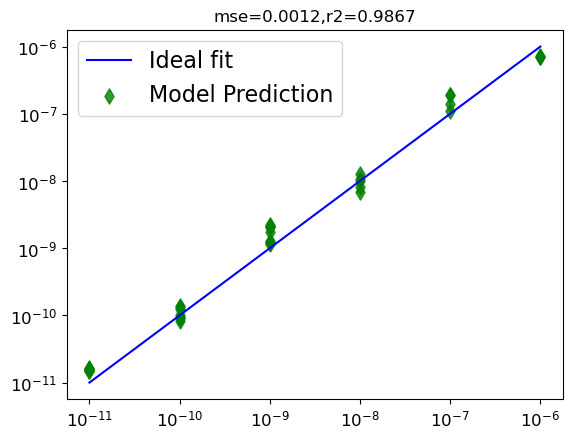

In [26]:
def unnorm(y):
    return y * (Y.max() - Y.min())+Y.min()
from sklearn.metrics import r2_score, mean_squared_error
#pc_test =pca.transform(X_test)
pc_test=np.matmul(X_test,batch.T)
pc_test=(pc_test-np.min(pc,axis=0))/(np.max(pc,axis=0)-np.min(pc,axis=0))
#error = model.evaluate(pc_test,Y_test)
Y_pred = model.predict(pc_test)
test_r2=r2_score(unnorm(Y_test),unnorm(Y_pred))
error = mean_squared_error(Y_test,Y_pred)
alp=0.8
s=60
#min_concentration = np.max(c_list) * -1
x_ax=np.arange(np.min(c_list),np.max(c_list)  +1)
plt.plot(x_ax,x_ax,'b')
plt.scatter(unnorm(Y_test),unnorm(Y_pred),marker='d',color='green',alpha=alp,s=s)
plt.legend(['Ideal fit','Model Prediction'],fontsize=16)
ticks=[]
for c in x_ax:
    ticks.append("$10^{"+str(c)+"}$")
plt.xticks(1*x_ax,ticks,fontsize=12)
plt.yticks(1*x_ax,ticks,fontsize=12)
plt.title('mse={:.4f},r2={:.4f}'.format(error,test_r2))

## Cross-validation 

In [6]:
np.round(np.min(pc,axis=0),3)

array([-5.297, -1.638,  1.799,  0.177,  1.721, -1.799, -0.283,  0.353])

In [2]:
norm_high = np.array([-3.69 , -1.355,  2.006,  0.28 ,  1.777, -1.76 , -0.257,  0.38 ])
norm_low = np.array([-5.297, -1.637,  1.799,  0.177,  1.721, -1.799, -0.282,  0.353])

def parse_and_split(test_split_method,data_dir,model_dir,pca='fit'):
    remove_concentration= [0]
    wls = np.loadtxt(data_dir+'wavelengths.txt')
    X_an = np.load(data_dir+'X.npy')
    df = pd.read_csv(data_dir+'labels.csv')
    df['status'] = 'train'
    if test_split_method == 'batch':
        for concentration in df['concentration'].unique():
            batches = df[df['concentration'] == concentration]['batch'].unique()
            test_batches = np.random.choice(batches, max(1, len(batches) // 4), replace=False)
            df.loc[(df['concentration'] == concentration) & (df['batch'].isin(test_batches)), 'status'] = 'test'
    elif test_split_method== 'sample':
        test_samples = np.random.choice(df.index, max(1, len(df) // 5), replace=False)
        df.loc[df.index.isin(test_samples), 'status'] = 'test'
    df = df[~df['concentration'].isin(remove_concentration)]
    if os.path.isdir(model_dir):
        shutil.rmtree(model_dir)
    os.makedirs(model_dir)
    df.to_csv(model_dir+'labels.csv')
    X  = X_an.reshape(-1,201)[df.index]
    Y = np.array(df.concentration)
    Y_reg = (Y-Y.min()) / (Y.max()-Y.min())
    X_train = X[df.status=='train']
    Y_train = Y_reg[df.status=='train']
    X_test = X[df.status=='test']
    Y_test = Y_reg[df.status=='test']
    if pca =='fit':
        pca = PCA(n_components=8, svd_solver='full')
        pc=pca.fit_transform(X_train)
        pc_test =pca.transform(X_test)
    elif pca == 'mul':
        pca_components = np.load(data_dir+'pca_components.npy')
        pc = np.matmul(X_train,pca_components.T)
        pc = (pc-norm_low)/(norm_high-norm_low)
        pc_test=np.matmul(X_test,pca_components.T)
        pc_test=(pc_test-norm_low)/(norm_high-norm_low)
    return pc,Y_train,pc_test,Y_test

def train_test(pc,Y_train,pc_test,Y_test,model_dir):
    early_stopper = EarlyStopping(monitor='loss',patience=15)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,verbose=0,
                                  patience=4, min_lr=1e-6)
    model=Sequential(name='test')
    model.add(Dense(32,activation='relu',input_shape=(8,)))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mse',metrics='mae')
    history=model.fit(pc,Y_train,epochs=100,verbose=0,batch_size=8,
                  callbacks=[reduce_lr,early_stopper])
    Y_pred = model.predict(pc_test)
    test_r2=r2_score(Y_test,Y_pred)
    error = mean_squared_error(Y_test,Y_pred)
    model.save(model_dir+'model.keras')
    return test_r2, error

In [3]:
test_split_method = 'batch'
data_dir = './data/dopamine_uric/'
model_dir = './res/uric/test/'
pc,Y_train,pc_test,Y_test = parse_and_split(test_split_method,data_dir,model_dir,pca='mul')
test_r2, error =  train_test(pc,Y_train,pc_test,Y_test,model_dir)
print(test_r2)

I0000 00:00:1706361366.362805 3885779 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 0s 1ms/step
0.9816119714339265


In [28]:
repeat = 100
all_r2 = np.empty(repeat)
all_mse = np.empty(repeat)
for i in range(repeat):
    model_dir = f'./res/uric/{i}/'
    pc,Y_train,pc_test,Y_test = parse_and_split(test_split_method,data_dir,model_dir,pca='mul')
    test_r2, error =  train_test(pc,Y_train,pc_test,Y_test,model_dir)
    all_r2[i] = test_r2
    all_mse[i] = error
np.savetxt('./res/uric/r2.txt',all_r2)
np.savetxt('./res/uric/mse.txt',all_mse)

2/2 [==============================] - 0s 1ms/step


In [22]:
m = keras.models.load_model(model_dir+'model.keras')

2/2 [==============================] - 0s 1ms/step


0.9951161834166906

model1 test loss= 0.0007448399534163866 r2= 0.9934634855495788
model2 test loss= 0.0007828466330841606 r2= 0.9931299479019551


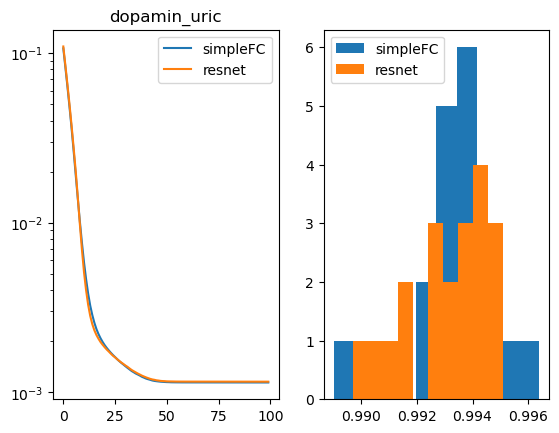

In [9]:
subsample = 201
window = 5
anchor = 145
repeat = 20
X_an,Y= parse_data(c_list,subsample,window,anchor,verbose=0)
metrics1 = None
for i in range(repeat):
    metrics1 = update_metrics(metrics1, train(X_an,Y,verbose=0))
metrics2 = None
for i in range(repeat):
    metrics2 = update_metrics(metrics2, train(X_an,Y,verbose=0))
plt.subplot(121)
plt.plot(np.mean(np.array(metrics1['loss']),axis=0))
plt.plot(np.mean(np.array(metrics2['loss']),axis=0))
plt.semilogy()
plt.legend(['simpleFC','resnet'])
plt.title('dopamin_uric')
plt.subplot(122)
plt.hist(metrics1['test_r2'])
plt.hist(metrics2['test_r2'])
plt.legend(['simpleFC','resnet'])
print(f'model1 test loss=',np.mean(metrics1['test_loss']),'r2=',np.mean(metrics1['test_r2']))
print(f'model2 test loss=',np.mean(metrics2['test_loss']),'r2=',np.mean(metrics2['test_r2']))

In [23]:
from tqdm import tqdm
subsample = 201
window = 5
anchor = 145
X_an,Y= parse_data(c_list,subsample,window,anchor,verbose=0)
metrics = []
for j in tqdm(range(100)):
    metrics.append(train(X_an,Y,verbose=0))
np.savetxt('metrics.txt',metrics)

  0%|                                                   | 0/100 [00:00<?, ?it/s]

  1%|▍                                          | 1/100 [00:04<07:48,  4.73s/it]

100%|█████████████████████████████████████████| 100/100 [06:49<00:00,  4.10s/it]


In [24]:
X_raw=[]
Y = [] 
for c in c_list:
    x2 = []
    y2= []
    #ref_high.append(savgol_filter(readtxt(f'B-10-{c}-{1}.txt', LOW, HIGH),21,3))
    #ref_low.append(savgol_filter(readtxt(f'D-10-{c}-{1}.txt', LOW, HIGH),21,3))
    for b in np.arange(10)+1:
        for i in [1,2,3]:
            x1 = savgol_filter(readtxt(f'{c}-10-{b}-{i}.txt', LOW, HIGH),21,3)
            x2.append(x1)
            y2.append(c)
    Y.append(y2)
    X_raw.append(x2)
X_raw = np.array(X_raw)
Y=np.array(Y)

In [25]:
from tqdm import tqdm
subsample = 201
window = 5
anchor = 145
wl=np.linspace(LOW_WL,HIGH_WL,subsample)
X_smo=subsample_and_smooth(X_raw.reshape(len(c_list),30,-1),wls,wl,window)
metrics_an=[]
for anchor in tqdm(range(subsample)):
    if anchor<20 or anchor>180:
        continue
    tmp_loss = []
    X_an=normalize_anchor(X_smo,anchor,length=X_smo.shape[-1])
    X_an=X_an.reshape(len(c_list),-1,X_smo.shape[-1])
    for i in range(20):
        tmp_loss.append(train(X_an,Y,verbose=0))
    metrics_an.append(np.array(tmp_loss))


100%|███████████████████████████████████████| 201/201 [3:40:29<00:00, 65.82s/it]


ValueError: Expected 1D or 2D array, got 3D array instead

In [28]:
np.save('loss_anchor.npy',np.array(metrics_an))

In [30]:
metrics_an = np.array(metrics_an)

In [32]:
metrics_an.shape

(161, 20, 2)

159


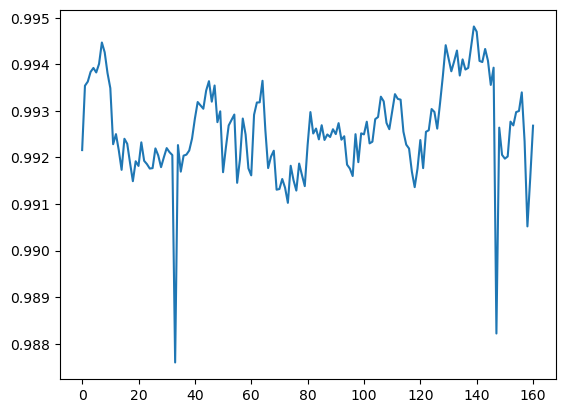

In [36]:
anchors = np.arange(20,181)
plt.plot(np.mean(metrics_an,axis=1)[:,1])
print(anchors[np.argmax(np.mean(metrics_an,axis=1)[:,1])])